# Build and Train Model

In [1]:
# Import libraries
import json
import torch

# Check GPU and set computing device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Declare data path constants (25% for validation)
data_dir = 'weather_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

# Label mapping
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Define transforms constants
trans_mean = [0.485, 0.456, 0.406]
trans_std = [0.229, 0.224, 0.225]

# Define training constants
batch_size = 32
num_out_features = 102

# Define model checkpoint path
checkpoint_path = 'Weather_Classifer_Checkpoint_01.pth'

### Load image datasets

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os

# Define transforms for training and validation sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(trans_mean, trans_std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(trans_mean, trans_std)
    ])
}

# Load the datasets with ImageFolder and DataLoader
image_datasets = { x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                     for x in [ 'train', 'valid' ]}

dataloaders = { x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
                   for x in [ 'train', 'valid' ]}

In [3]:
# Get loaded dataset properties
dataset_sizes = { x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

### Test Dataloader

label: 0, class: 0, name: cloudy


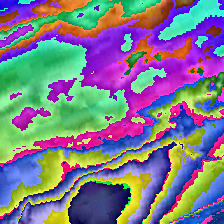

In [4]:
import numpy as np

# Test dataloader
images, labels = next(iter(dataloaders['train']))
rand_idx = np.random.randint(len(images))

print("label: {}, class: {}, name: {}".format(labels[rand_idx].item(),
                                             class_names[labels[rand_idx].item()],
                                             cat_to_name[class_names[labels[rand_idx].item()]]))

to_pil = transforms.ToPILImage()
to_pil(images[0])

### Build Model

In [5]:
from torchvision import models

model_name = 'densenet' #vgg
if model_name == 'densenet':
    model = models.densenet161(pretrained=True)
    num_in_features = 2208
    print(model)
elif model_name == 'vgg':
    model = models.vgg19(pretrained=True)
    num_in_features = 25088
    print(model.classifier)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [6]:
from torch import nn

# Create Classifier
for param in model.parameters():
    param.requires_grad = False
    
def build_classifier(num_in_features, hidden_layers, num_out_features):
    classifier = nn.Sequential()
    
    if hidden_layers == None:
        classifier.add_module('fc0', nn.Linear(num_in_features, num_out_features))
    else:
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        classifier.add_module('fc0', nn.Linear(num_in_features, hidden_layers[0]))
        classifier.add_module('relu0', nn.ReLU())
        classifier.add_module('drop0', nn.Dropout(.6))
        classifier.add_module('relu1', nn.ReLU())
        classifier.add_module('drop1', nn.Dropout(.5))
        
        for i, (h1, h2) in enumerate(layer_sizes):
            classifier.add_module('fc' + str(i+1), nn.Linear(h1, h2))
            classifier.add_module('relu' + str(i+1), nn.ReLU())
            classifier.add_module('drop' + str(i+1), nn.Dropout(.5))
            
        classifier.add_module('output', nn.Linear(hidden_layers[-1], num_out_features))
        
    return classifier

In [7]:
from torch import optim

hidden_layers = None #[4096, 1024, 256][512, 256, 128]

classifier = build_classifier(num_in_features, hidden_layers, num_out_features)
print(classifier)

# Only train classifier parameters, feature parameters are frozen
model.classifier = classifier
if model_name == 'densenet':
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adadelta(model.parameters())
    sched = optim.lr_scheduler.StepLR(optimizer, step_size=4)
elif model_name == 'vgg':
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
    sched = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

Sequential(
  (fc0): Linear(in_features=2208, out_features=102, bias=True)
)


### Train Model

In [8]:
import copy
import time

def train_model(model, criterion, optimizer, sched, num_epochs=5):
    training_start = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        
        epoch_start = time.time()
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward + track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # Deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        time_elapsed = time.time() - epoch_start
        print('Epoch complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print()
    
    time_elapsed = time.time() - training_start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

In [9]:
epochs = 30

model.to(device)
model = train_model(model, criterion, optimizer, sched, epochs)

Epoch 1/30
----------
train Loss: 1.1190 Acc: 0.5917
valid Loss: 0.4485 Acc: 0.8958
Epoch complete in 2m 37s

Epoch 2/30
----------
train Loss: 0.4499 Acc: 0.8561
valid Loss: 0.3413 Acc: 0.9018
Epoch complete in 2m 36s

Epoch 3/30
----------
train Loss: 0.3722 Acc: 0.8852
valid Loss: 0.3348 Acc: 0.9048
Epoch complete in 2m 34s

Epoch 4/30
----------
train Loss: 0.2750 Acc: 0.9135
valid Loss: 0.4634 Acc: 0.8244
Epoch complete in 2m 35s

Epoch 5/30
----------
train Loss: 0.2727 Acc: 0.9069
valid Loss: 0.3122 Acc: 0.8780
Epoch complete in 2m 32s

Epoch 6/30
----------
train Loss: 0.2497 Acc: 0.9210
valid Loss: 0.1567 Acc: 0.9435
Epoch complete in 2m 31s

Epoch 7/30
----------
train Loss: 0.2302 Acc: 0.9276
valid Loss: 0.1019 Acc: 0.9702
Epoch complete in 2m 33s

Epoch 8/30
----------
train Loss: 0.2330 Acc: 0.9135
valid Loss: 0.1124 Acc: 0.9643
Epoch complete in 2m 30s

Epoch 9/30
----------
train Loss: 0.2225 Acc: 0.9257
valid Loss: 0.2082 Acc: 0.9137
Epoch complete in 2m 32s

Epoch 10/3

### Evaluate and Save Model

In [10]:
# Evaluation
model.eval()

accuracy = 0
for inputs, labels in dataloaders['valid']:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    
    # Class with highest probability is the predicted class
    equality = (labels.data == outputs.max(1)[1])
    
    # Accuracy = # of correct predictions / # of total predictions
    accuracy += equality.type_as(torch.FloatTensor()).mean()

print("Test accuracy: {:.3f}".format(accuracy / len(dataloaders['valid'])))

Test accuracy: 0.989


In [11]:
# Save model
model.class_to_idx = image_datasets['train'].class_to_idx

checkpoint = {
    'input_size': num_in_features,
    'output_size': num_out_features,
    'epochs': epochs,
    'batch_size': batch_size,
    'model': models.densenet161(pretrained=True),
    'classifier': classifier,
    'scheduler': sched,
    'optimizer': optimizer.state_dict(),
    'state_dict': model.state_dict(),
    'class_to_idx': model.class_to_idx
}

torch.save(checkpoint, checkpoint_path)

# Load Model and Make Predictions

In [35]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms

data_dir = 'weather_data'
test_image_path = 'weather_data/valid/1/rain111.jpg'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [36]:
# Load checkpoint and rebuild model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    optimizer = checkpoint['optimizer']
    epochs = checkpoint['epochs']
    
    for param in model.parameters():
        param.requires_grad = False
        
    return model

In [37]:
# Load model and image
model = load_checkpoint(checkpoint_path)

img = Image.open(test_image_path)

In [38]:
# Scale, crop, normalize and convert PIL image into numpy array for PyTorch model
def process_image(image):
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    
    image = preprocess(image)
    return image

# Imshow for Tensor
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    # Color channel is first dimension for PyTorch tensors, and third for matplotlib
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Clip image to be between 0 and 1 to remove noised when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

### Original Image

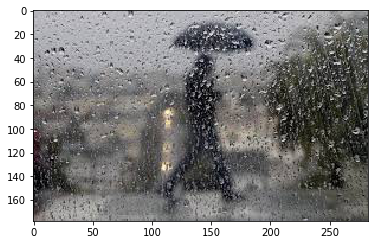

In [39]:
# Show image
plt.imshow(img)

### Transformed Image

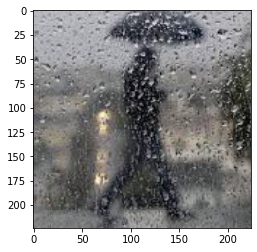

In [40]:
imshow(process_image(img))

## Class Prediction

In [41]:
# Define your transforms for the training and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}

# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                      for x in ['train', 'valid']}

class_names = image_datasets['train'].classes

# Label mapping
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [42]:
# Predict the class(es) of an image using the trained model
def predict(image_path, model, topk=3):
    
    # Open image and convert 2D image to 1D vector
    img = process_image(Image.open(image_path))
    img = np.expand_dims(img, 0)
    img = torch.from_numpy(img)
    
    model.eval()
    inputs = Variable(img).to(device)
    logits = model.forward(inputs)
    
    ps = F.softmax(logits, dim=1)
    topk = ps.cpu().topk(topk)
    
    return (e.data.numpy().squeeze().tolist() for e in topk)

In [43]:
# View image and its predicted classes
def view_classify(image_path, prob, classes, mapping):
    image = Image.open(image_path)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    weather_name = mapping[image_path.split('/')[-2]]
    ax1.set_title(weather_name)
    ax1.imshow(image)
    ax1.axis('off')
    
    y_pos = np.arange(len(prob))
    ax2.barh(y_pos, prob, align='center')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(weather_names)
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.set_title('Class Probability')

In [44]:
probs, classes = predict(test_image_path, model.to(device))
print(probs)
print(classes)

weather_names = [cat_to_name[class_names[e]] for e in classes]
print(weather_names)

[0.9999997615814209, 9.608123718862771e-08, 8.907171178407225e-08]
[1, 3, 2]
['rain', 'sunrise', 'shine']


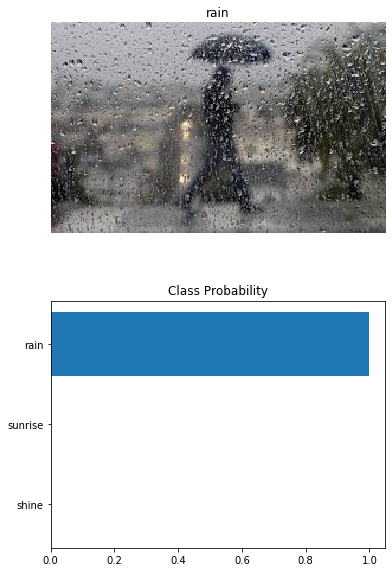

In [45]:
view_classify(test_image_path, probs, classes, cat_to_name)